# Imports

In [1]:
import sklearn
import pandas as pd
import numpy as np

from urllib.parse import parse_qsl, urljoin, urlparse
from sklearn.model_selection import cross_val_score 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

pd.set_option('display.max_columns', None) #display all the columns in pandas head function

np.random.seed(42)

import re
import requests
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_predict


random_state = 42
cv_results = np.array([])
cv_means = []
cv_std = []
cvk=10

In [3]:
#in case you are using local machine
df =pd.read_csv('malicious_phish.csv')

In [4]:
#please specify the path of the dataset inside the read_csv

# Overview of the Dataset

Let begin our analysis by looking at the dataset

In [5]:
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [6]:
print(df.shape)

(651191, 2)


As can be seen the dataset is composed of many rows (instances), but it has only two columns and one of these two columns is the target value, which only leave one column for us to train our model.
ofcourse this is infeasible, therefore we will conduct feature extraction from the first column before we do anything else inorder to make our model work

but before we begin the feature extraction process let see the distribution of our labels

In [7]:
df["type"].describe()

count     651191
unique         4
top       benign
freq      428103
Name: type, dtype: object

In [8]:
df["type"].value_counts()


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x2a7263db4d0>,
 [Text(-0.5220846877148526, 0.9682084377104369, 'Benign'),
  Text(-0.12773036260591056, -1.0925589020590893, 'Defacement'),
  Text(0.7913806562888462, -0.7640135187624859, 'Phishing'),
  Text(1.0864899607286258, -0.1718707806344909, 'Malware')])

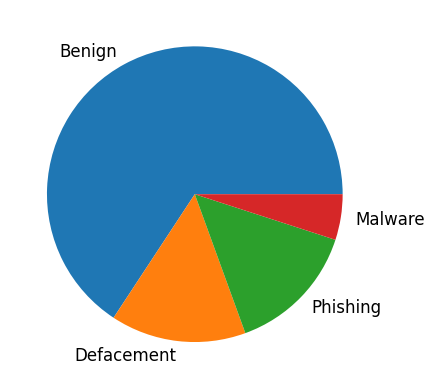

In [9]:
lis=[df["type"].value_counts()[0],df["type"].value_counts()[1],df["type"].value_counts()[2],df["type"].value_counts()[3]]
plt.pie(lis,labels=["Benign","Defacement","Phishing","Malware"])


As can be seen above we have four classes, which means our task is considered to be a multi-class task, further more the "benign" label is the label with the most occurance, so we will need to take that into our consideration when we evaluate our model

# URL Components

URLS conisists minimally of three components and up to 9 componenets in the case of complex URLs

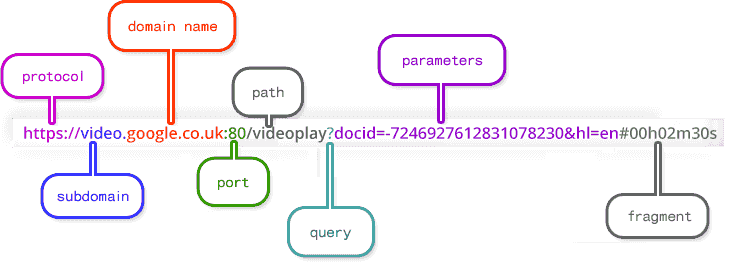

Figure source:https://medium.com/@joseph.pyram/9-parts-of-a-url-that-you-should-know-89fea8e11713



As can be seen from the figure above, these are the components of a complex url, the URL in shown in the figure is a special case where all of the components are shown, in the general case 5 of such components is present in a URL, because the domain part and the sub domain part are typically both treated as one and is called the domain name, the port is rarely present in a url. The same thing applies for the query as its typically results from user interaction for example searching for something in google

We will extract the six most relevant components  of the above components from our URLs datasets namely:

1- The protocol

2-The domain name (subdomain + domain)

3- The path

4- The parameters

5-The query

6- The fragment

After extracting these componenets more features will be extracted from it

# URL Components Extraction

In [10]:
df["original_url"]=df["url"]

In [11]:
def fix_url(url): #if no protocol (scheme) is used assume the general case of http, this is needed to make the urlparse function works
  if not urlparse(url).scheme:
        return f"http://{url}"
  return url

In [12]:
def get_protocol(url):
  protocol, _, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip() )
  return protocol

In [13]:
def get_host(url):
  _, host, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return host

In [14]:
def get_path(url):
  _, _, path, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return path

In [15]:
def get_parameters(url):
  _, _, _, parameters, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return parameters

In [16]:
def get_query(url):
  _, _, _, _, query, _ = urlparse(url.replace("[","").replace("]","").strip())
  return query

In [17]:
def get_fragment(url):
  _, _, _, _, _, fragment = urlparse(url.replace("[","").replace("]","").strip())
  return fragment

In [18]:
df["url"]=df["url"].apply(fix_url)

In [19]:
df

,url,type,original_url
0,http://br-icloud.com.br,phishing,br-icloud.com.br
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...
...,...,...,...
651186,http://xbox360.ign.com/objects/850/850402.html,phishing,xbox360.ign.com/objects/850/850402.html
651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,phishing,games.teamxbox.com/xbox-360/1860/Dead-Space/
651188,http://www.gamespot.com/xbox360/action/deadspace/,phishing,www.gamespot.com/xbox360/action/deadspace/
651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,phishing,en.wikipedia.org/wiki/Dead_Space_(video_game)


In [20]:
df["protocol"]=df["url"].apply(get_protocol)

In [21]:
df["host"]=df["url"].apply(get_host)
df.head()

,url,type,original_url,protocol,host
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net


In [22]:
df["path"]=df["url"].apply(get_path)
df.head()

,url,type,original_url,protocol,host,path
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php


In [23]:
df["parameters"]=df["url"].apply(get_parameters)
df.sample(10)

,url,type,original_url,protocol,host,path,parameters
536448,http://37.49.226.178/deusbins/deus.sh4,malware,http://37.49.226.178/deusbins/deus.sh4,http,37.49.226.178,/deusbins/deus.sh4,
40630,http://medical-dictionary.thefreedictionary.co...,benign,medical-dictionary.thefreedictionary.com/Galt+...,http,medical-dictionary.thefreedictionary.com,/Galt+trephine,
630496,http://www.jscape.com/sshfactory/,phishing,www.jscape.com/sshfactory/,http,www.jscape.com,/sshfactory/,
426724,http://www.wsnc.org.au/component/jcalpro/view/983,defacement,http://www.wsnc.org.au/component/jcalpro/view/983,http,www.wsnc.org.au,/component/jcalpro/view/983,
184034,http://virtualtourist.com/travel/North_America...,benign,virtualtourist.com/travel/North_America/Canada...,http,virtualtourist.com,/travel/North_America/Canada/Province_of_Quebe...,
72922,http://evri.com/person/donald-ballard-0x87e96,benign,evri.com/person/donald-ballard-0x87e96,http,evri.com,/person/donald-ballard-0x87e96,
91279,http://www.sweethome.com.gr/index.php?option=c...,defacement,http://www.sweethome.com.gr/index.php?option=c...,http,www.sweethome.com.gr,/index.php,
618950,http://www.msnbc.msn.com/?id=3475953,phishing,www.msnbc.msn.com/?id=3475953,http,www.msnbc.msn.com,/,
432803,http://www.mruniquespaving.co.uk/paved-drivewa...,defacement,http://www.mruniquespaving.co.uk/paved-drivewa...,http,www.mruniquespaving.co.uk,/paved-driveway-gallery,
171655,http://torcache.net/torrent/4646B1C156C01B1D1B...,benign,http://torcache.net/torrent/4646B1C156C01B1D1B...,http,torcache.net,/torrent/4646B1C156C01B1D1B8FDC82282E80C593890...,


In [24]:
df["query"]=df["url"].apply(get_query)
df.head()

,url,type,original_url,protocol,host,path,parameters,query
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,,
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,,option=com_content&view=article&id=70&vsig70_0=15
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,,option=com_mailto&tmpl=component&link=aHR0cDov...


In [25]:
df["fragment"]=df["url"].apply(get_fragment)

In [26]:
df.head()

,url,type,original_url,protocol,host,path,parameters,query,fragment
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,,,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,,,
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,,option=com_mailto&tmpl=component&link=aHR0cDov...,


Now that we have extracted all the components, let analyze it to see which components is revelant to our analysis

In [27]:
df = df.replace('', np.nan) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651191 non-null  object
 1   type          651191 non-null  object
 2   original_url  651191 non-null  object
 3   protocol      651191 non-null  object
 4   host          651025 non-null  object
 5   path          628145 non-null  object
 6   parameters    325 non-null     object
 7   query         139969 non-null  object
 8   fragment      461 non-null     object
dtypes: object(9)
memory usage: 44.7+ MB


As can be seen the Parameters , Query and Fragment has many empty values, therefore we can safely drop such a features.

The host (domain name) part has 183 empty values, having a url with no domain name doesn't make alot of sense in our project, also 183 is relatively a small amount compared to the whole dataset, therefore we can safely drop all the instance that has no domain name

In [28]:
df.drop(['parameters', 'query','fragment'], axis = 1,inplace=True)
df.dropna(subset = ['host'],inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651025 entries, 0 to 651190
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651025 non-null  object
 1   type          651025 non-null  object
 2   original_url  651025 non-null  object
 3   protocol      651025 non-null  object
 4   host          651025 non-null  object
 5   path          627979 non-null  object
dtypes: object(6)
memory usage: 34.8+ MB


Finally the Path part also has some missing values;however it consistes a huge portion of our datasets,also having such an empty path in a url is normal for example "www.google.com",therefore we will fill these empty values with spaces,as this will not affect the next process as we will see soon.

In [30]:
df.fillna("",inplace=True)

In [31]:
df.reset_index(drop=True,inplace=True)

# Feature Extraction

We will begin our feature extraction journey by extracting features related to the whole URL itself, after that more features will be extracted for every component individually

# URL Features

**Presense of an IP address in the URL**

Every website has an IP address associated with it, which is simpliy used to tell your device where to direct it's requests. most websites has a Domain name assosiated with it's IP to make it easier for us (as humans) to remeber how to access a certain website.

every website is accessable using either its IP address of it name, and here we will check whether a URL in the dataset is IP or name based:

In [32]:
def ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['ip_address'] = df['url'].apply(ip_address)

**Special symbols in the URL**

Most of the time malicious URLs contains specail symbols that might alter how the bowser treats such URL, for example the "@" symbol leads the browser to ignore everything preceding it, which means that the real address where you will be redirected is ofter after such symbol, hence an attacker can inject the name of a legitimate URL before it to trick you into visiting such website.


Another popularly used symbol is the " - " which is rarely used in legitimate websites, but used alot in malicious ones inorder to make the domain name looks good for the user and remove an suspiciousness that the user might have, or to trick the user into beliveing that he is visiting a legitimate website.
for example a malicious website that imitate the facebook might look like this
"www.face-book.com", unless the user is carefull, he can fall easliy in such simple trick.

The following is a list of some popularly used symbols in URLs

  ?    -  =   .    #    %   +    $  !  *  ,

In [33]:
def specialSymbols(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"URL_{symbol}"] = df['url'].apply(lambda i: i.count(symbol))

specialSymbols(df)

**Length of the URL**

The official length of a URL is 2048 characters, so regardless whether a URL is malicious or not, it has to obay this rule.
Begnin websites normally uses short URLs, on the otherside some malicious websites uses long URLs to hide some information such as the special symbols mentioned above, therefore such feature might be useful in our analysis

In [34]:
def getLength(url):
  return len(url)

In [35]:
df["length"] = df["url"].apply(getLength)

**Usage of a URL Shortening Services**

Using URL Shortening Services is a third party websites that is used to convert long URLs in short ones using the http redirect on the domain name of the shorting service website.

such service is used by many attackers to hide some of the info in the original URL (the long URL), and to trick the users into beliving that the website is safe,as theses services is seen alot by the users in thier daily browsing.

In [36]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['Shortining'] = df['url'].apply(Shortining_Service)

**Digits counts in a URL**



In [37]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [38]:
df['digits_in_url']= df['url'].apply(digit_count)

**letters counts in a URL**

It might also be useful to include the letter count in our analysis,if this feature turns out to be useless we can always drop it out


In [39]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [40]:
df['letters_in_url']= df['url'].apply(letter_count)

**E-mail Address in URL**

It's pretty rare to find an E-mail address inside of a websites URL, most big websites avoid having an E-mail address inside any of thier URLs to protect the users privacy and to protect the users from spam bots that might detect such E-mails and start sending advertisments to it, therefore having an E-mail inside a URL might be a good indication about the type of the URL that a person might visit.

In [41]:
def EmailAddress(url):
    if re.findall(r'[\w\.-]+@[\w\.-]+', url):
        return 1
    else:
        return 0

df['email_address']= df['url'].apply(EmailAddress)

**Counting vowels**

In [42]:
def vowels_count(url):
    vowels = ['a', 'e', 'i', 'o', 'u']
    count = 0
    for i in vowels:
        count += url.lower().count(i)
    return count


In [43]:
df['vowels_url']= df['url'].apply(vowels_count)

**TLD count**

A top-level domain is a group of letters that appear as part of a website address URL, for exmaple if we have the following URL : "www.google.com", the TLD is ".com" , it is mainly used for DNS resolving.

Typically a website might has 1 or 2 TLDs in its URL.

In this feature we have a list of all of the possible TLDs, and will use it to count the TLDs inside of a URL

In [44]:
tld_file = open('tld.txt', 'r') #displaying the TLDs list

print(tld_file.readlines() )

tld_file.close()

['AAA\n', 'AARP\n', 'ABB\n', 'ABBOTT\n', 'ABBVIE\n', 'ABC\n', 'ABLE\n', 'ABOGADO\n', 'ABUDHABI\n', 'AC\n', 'ACADEMY\n', 'ACCENTURE\n', 'ACCOUNTANT\n', 'ACCOUNTANTS\n', 'ACO\n', 'ACTOR\n', 'AD\n', 'ADS\n', 'ADULT\n', 'AE\n', 'AEG\n', 'AERO\n', 'AETNA\n', 'AF\n', 'AFL\n', 'AFRICA\n', 'AG\n', 'AGAKHAN\n', 'AGENCY\n', 'AI\n', 'AIG\n', 'AIRBUS\n', 'AIRFORCE\n', 'AIRTEL\n', 'AKDN\n', 'AL\n', 'ALIBABA\n', 'ALIPAY\n', 'ALLFINANZ\n', 'ALLSTATE\n', 'ALLY\n', 'ALSACE\n', 'ALSTOM\n', 'AM\n', 'AMAZON\n', 'AMERICANEXPRESS\n', 'AMERICANFAMILY\n', 'AMEX\n', 'AMFAM\n', 'AMICA\n', 'AMSTERDAM\n', 'ANALYTICS\n', 'ANDROID\n', 'ANQUAN\n', 'ANZ\n', 'AO\n', 'AOL\n', 'APARTMENTS\n', 'APP\n', 'APPLE\n', 'AQ\n', 'AQUARELLE\n', 'AR\n', 'ARAB\n', 'ARAMCO\n', 'ARCHI\n', 'ARMY\n', 'ARPA\n', 'ART\n', 'ARTE\n', 'AS\n', 'ASDA\n', 'ASIA\n', 'ASSOCIATES\n', 'AT\n', 'ATHLETA\n', 'ATTORNEY\n', 'AU\n', 'AUCTION\n', 'AUDI\n', 'AUDIBLE\n', 'AUDIO\n', 'AUSPOST\n', 'AUTHOR\n', 'AUTO\n', 'AUTOS\n', 'AVIANCA\n', 'AW\n', 'AWS\n', 

In [45]:
tld_file = open('tld.txt', 'r')
def TLD_count(url):
    tldcount = 0
    tld_list=tld_file.readlines()
    line=0
    while (line < len(tld_list)):
       if tld_list[line].rstrip() in url :
          tldcount+=1
          line+=10
       line+=1
    if(".php" in url):
      tldcount-=1;
    if(".html" in url):
      tldcount-=1;

    tld_file.seek(0)
    return tldcount

df['tld_count']= df['url'].apply(TLD_count)


In [46]:
# if any error occurrs please provide path name fot tld.txt file.
# Eg: Downloads\\Submission\\tld.txt

**Precense of the word 'Server' or 'Client'**

In [47]:
def check_word_server_client(url):
    if "server" in url.lower() or "client" in url.lower():
        return 1
    return 0
df['server_client']= df['url'].apply(check_word_server_client)

**protocol type**

in our dataset we have three types of protocols ,http, https, and ftp, for each of such protocols we will create a feature that indicates if the url uses such protocol

we will not use the protocol feature that we extracted here because we filled the urls that doesn't contain any url with http to make the urlparse function work.

**Usage of https**

https (Hyper Text Transfer Protocol Secure) is a protocol built on the http protocol with the addition of an encryption layer, which means that the connection between your browser and the target website is secure and can not be intercepted by a malicious entity, it is a common misunderstanding nowadays that all https websites are safe, this is true in term of the connection only,not the website itself as anyone could implement such protocol easily in his website to trick users into entering it.

In [48]:
def https(url):
    if str(urlparse(url).scheme)=='https':
        return 1
    else:
        return 0

df['https'] = df['original_url'].apply(https)

In [49]:
def http(url):
    if str(urlparse(url).scheme)=='http':
        return 1
    else:
        return 0

df['http'] = df['original_url'].apply(http)

In [50]:
def ftp(url):
    if str(urlparse(url).scheme)=='ftp':
        return 1
    else:
        return 0

df['ftp'] = df['original_url'].apply(ftp)

# Path Features

As for the path features we will extract simillar features as the ones we extracted for the URL

In [51]:
def specialSymbols2(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"path_{symbol}"] = df['path'].apply(lambda i: i.count(symbol))

specialSymbols2(df)

In [52]:
df["path_length"] = df["path"].apply(getLength)
df['path_digits_in_url']= df['path'].apply(digit_count)
df['path_letters_in_url']= df['path'].apply(letter_count)
df['path_vowels_url']= df['path'].apply(vowels_count)


# Host Features

**Digits counts in a domain name**

Digits inside a URL's domain can also be an indication of the status of a website in term of it being benigin or not,a malicious entity can use numarical digits inorder to trick the user into beliving that he is visiting a normal website.
for example an attacker might make a website with the following URL "www.facebo0k.com", notice that the second "o" is actually a zero, and anyone can easily fall in this simple trick.

In [53]:
def specialSymbols3(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"host_{symbol}"] = df['host'].apply(lambda i: i.count(symbol))

specialSymbols3(df)

In [54]:
df["host_length"] = df["host"].apply(getLength)
df['host_digits_in_url']= df['host'].apply(digit_count)
df['host_letters_in_url']= df['host'].apply(letter_count)
df['host_vowels_url']= df['host'].apply(vowels_count)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651025 entries, 0 to 651024
Columns: 116 entries, url to host_vowels_url
dtypes: int64(110), object(6)
memory usage: 576.2+ MB


# Feature Engineering

Now that we have extracted all the features that we need, let take a look at it once again

In [56]:
df.head()

,url,type,original_url,protocol,host,path,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,23,0,0,17,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,13,4
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,4,0,1,0,0,0,0,0,0,0,0,0,42,0,1,33,0,9,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,24,0,20,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,9,3
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,38,0,1,29,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,17,1,12,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,13,4
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,0,2,3,0,0,0,0,1,1,4,3,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,88,0,7,63,0,22,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,8,2,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,18,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,0,1,2,0,0,0,0,1,1,3,2,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,235,0,22,199,0,37,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,8,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,21,10


In [57]:
df.describe()

,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
count,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.00000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.0,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.0,651025.0,651025.00000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.0,651025.000000,651025.000000,651025.00000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000
mean,0.019182,0.422945,0.380540,0.013445,0.000058,0.013466,0.00222,0.223804,1.550733,0.603931,2.195332,0.000871,0.519604,0.068447,0.000238,0.000954,0.000395,0.004825,1.003749,4.372863,0.038865,1.053559,0.000075,0.000078,0.000129,0.002416,0.002416,0.000284,0.000289,0.006083,0.006066,65.136566,0.061051,5.527164,48.093107,0.001676,15.254844,-0.031366,0.004094,0.024085,0.264686,0.000003,0.286123,0.003359,0.013310,0.000003,0.002625,0.000885,0.0,1.284192,0.009258,0.509882,0.0,0.378205,0.045324,0.000078,0.000484,0.000178,0.004049,0.001528,2.317032,0.001045,0.004805,0.000015,0.000017,0.000023,0.0,0.0,0.000008,0.000017,0.005650,0.005645,28.784928,3.057864,20.848093,7.151069,0.000198,0.000028,0.000026,0.000040,0.006027,0.000029,0.0,0.133457,0.000026,1.599343,0.0,0.000149,0.000041,0.000022,0.000029,0.000031,0.0,0.0,0.0,0.00002,0.007668,0.000026,0.000026,0.000040,0.0,0.0,0.000029,0.000025,0.00002,0.000029,17.396748,0.632363,15.015024,5.347429
std,0.137165,1.173656,1.224219,0.117716,0.011359,0.161294,0.05419,0.441239,2.974074,1.517055,1.490828,0.032331,4.462810,0.621353,0.023547,0.039551,0.074948,0.152447,0.068602,1.650435,0.558549,0.302824,0.014821,0.014293,0.018299,0.050240,0.050025,0.018753,0.018794,0.083838,0.083573,43.662721,0.239425,11.701532,31.057570,0.040902,10.265188,1.328421,0.063850,0.153314,0.441166,0.001753,1.067898,0.105468,0.116499,0.001753,0.053459,0.032591,0.0,2.874548,0.141740,0.695815,0.0,3.755854,0.508936,0.010443,0.029194,0.068312,0.142917,0.039533,1.566967,0.057458,0.086552,0.006072,0.006197,0.007539,0.0,0.0,0.002771,0.004469,0.080026,0.080016,27.999202,7.077647,19.804190,7.349687,0.015822,0.006072,0

As can be seen some of the features above has only zero values, therefore we will be dropping it as it will be useless for our model


In [58]:
df.drop(["path_?","path_#","path_[","path_]","host_?","host_#","host_,","host_//","host_/","host_[","host_]",],axis=1,inplace=True)

The Protocol attribute should also be dropped as we have already expanded it to three features :http, https, ftp

In [59]:
df.drop(["protocol"],axis=1,inplace=True)

we also need to drop the categorical columns such as the url , host, path, as we have already extracted the features that we need from it

In [60]:
df.drop(["url","path","host","original_url"],axis=1,inplace=True)

It can be seen that some of the features has a really low mean, this indicates that such features rarely appeares in any URL, Therefore we will merge some of these features together to reduce the dimensionality

In [61]:
df["host_><^{}()!;:~"]=df["host_<"]+df["host_>"]+df["host_^"]+df["host_}"] +df["host_{"]+df["host_("] +df["host_)"]+df["host_!"]+df["host_;"]+df["host_:"]+df["host_~"]
df.drop(["host_<","host_>","host_^","host_}","host_{","host_(","host_)","host_!","host_:","host_;"],axis=1,inplace=True)

In [62]:
df["path_><^{}()!;:'~"]=df["path_<"]+df["path_>"]+df["path_^"]+df["path_}"] +df["path_{"]+df["path_("] +df["path_)"]+df["path_!"]+df["path_;"]+df["path_:"]+df["path_'"]+df['path_"']+df['path_~']
df.drop(["path_<","path_>","path_^","path_}","path_{","path_(","path_)","path_!","path_:","path_;",'path_"',"path_'",'path_~'],axis=1,inplace=True)

In [63]:
df["URL_><^{}()[]!;:'~"]=df["URL_<"]+df["URL_>"]+df["URL_^"]+df["URL_}"] +df["URL_{"]+df["URL_("] +df["URL_)"]+df["URL_["]+df["URL_]"]+df["URL_!"]+df["URL_;"]+df["URL_:"]+df["URL_'"]+df['URL_"']+df['URL_~']
df.drop(["URL_<","URL_>","URL_^","URL_}","URL_{","URL_(","URL_)","URL_!","URL_:","URL_;","URL_[","URL_]","URL_'",'URL_"','URL_~'],axis=1,inplace=True)

In [64]:
df['https+ftp']=df['https']+df['ftp']
df.drop(["https","ftp"],axis=1,inplace=True)

Finally we need to encode our labels inorder to be able to feed it into the ML algorithms

In [65]:
df["type"] = df["type"].astype('category')
df["type"] = df["type"].cat.codes

Everything seems well too far however as most of the ML algorithms that we will be using next uses to gradient decsent algorithm, we need to make sure that our data has the same scale inorder to be able to converge fast to the optimal solution.

we will standarize our data for this porpose, so that it end up with 0 mean and a standard deviation of 1

In [66]:
types=pd.DataFrame()
types["type"]=df["type"].copy()
df.drop(["type"],axis=1,inplace=True)

In [67]:
columns=df.columns

In [68]:
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
df=stdScaler.fit_transform(df)

In [69]:
df=pd.DataFrame(df,columns=columns)

In [70]:
df.describe()

,ip_address,URL__,URL_&,URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_*,"URL_,",URL_//,URL_/,length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,http,path__,path_&,path_@,path_-,path_=,path_.,path_%,path_+,path_$,path_*,"path_,",path_//,path_/,path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_-,host_=,host_.,host_%,host_+,host_$,host_*,host_length,host_digits_in_url,host_letters_in_url,host_vowels_url,host_><^{}()!;:~,path_><^{}()!;:'~,URL_><^{}()[]!;:'~,https+ftp
count,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05
mean,6.810471e-17,3.667177e-18,5.029271e-17,-5.719049e-18,1.536722e-17,-6.286588e-18,1.501796e-17,-8.731373e-18,-5.413451e-18,-1.789931e-17,-1.885976e-17,2.051873e-18,6.875956e-19,-8.775030e-18,9.573077e-16,-1.589110e-17,1.459886e-16,4.453000e-17,-1.222392e-17,4.156133e-17,4.453000e-18,-8.626596e-17,-1.344631e-17,2.307265e-17,-4.330761e-17,-7.788384e-17,3.972775e-18,1.373008e-17,5.168973e-17,5.980990e-18,3.806878e-17,-1.589110e-17,2.898816e-17,8.021949e-19,-9.604510e-19,-3.689005e-18,2.706726e-18,-8.678984e-17,-1.257318e-17,5.937333e-18,-3.300459e-17,-1.362094e-17,1.082690e-17,5.271566e-18,-1.527990e-19,-1.817217e-18,-2.534281e-17,-3.328836e-19,4.592702e-17,9.768223e-19,-1.920902e-17,-1.462505e-18,-6.368445e-18,6.652215e-18,1.347906e-18,1.907368e-16,1.938365e-17,3.754490e-17,-5.168973e-17,-2.287620e-17,-1.606573e-17,2.605769e-17,3.125831e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.398471e-01,-3.603660e-01,-3.108432e-01,-4.095893e-02,-5.072171e-01,-5.214175e-01,-3.980946e-01,-1.472560e+00,-2.693818e-02,-1.164298e-01,-1.101588e-01,-1.011117e-02,-5.267176e-03,-3.164841e-02,-5.465569e-02,-1.437721e+00,-1.308590e+00,-2.549922e-01,-4.723457e-01,-1.419723e+00,-4.097111e-02,-1.486077e+00,-1.481937e+00,-6.411217e-02,-5.999689e-01,-2.679308e-01,-3.185159e-02,-2.714755e-02,-4.467459e-01,-6.531482e-02,-7.327847e-01,-1.006976e-01,-8.905626e-02,-7.501608e-03,-2.608355e-03,-2.833116e-02,-3.865997e-02,-1.478674e+00,-1.028063e+00,-4.320456e-01,-1.052712e+00,-9.729768e-01,-1.252366e-02,-4.553785e-03,-4.597747e-03,-4.231208e-03,-7.781166e-02,-4.709660e-03,-2.577198e-01,-4.833685e-03,-1.497848e+00,-2.117599e-03,-4.780484e-03,-4.089748e-03,-4.525588e-03,-1.450132e+00,-1.717679e-01,-1.775181e+00,-1.691166e+00,-8.265480e-02,-1.425505e-01,-1.897058e-01,-1.571074e-01
25%,-1.398471e-01,-3

with this our features hasa mean of approximitly zero , and a standard deviation of one

let add the  labels back

In [71]:
df["type"]=types["type"]

Now we will split our dataset into train and test sets.

In [72]:
from sklearn.model_selection import train_test_split

y = df["type"]
X = df.drop(labels = ["type"], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [73]:
y_test.describe()

count    130205.000000
mean          0.686756
std           1.090876
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [74]:
y_train.describe()

count    520820.000000
mean          0.680316
std           1.087427
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

as we have discussed above our dataset is not balaced,causing the mean and the std in each set to be slightly different , therefore we will be using stratified splitting to insure that the same percentage of url labels exist within each set, this will help us in evalutaing our model more accurately.

In [75]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["type"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train =  strat_train_set.drop("type",axis=1)
y_train =  strat_train_set["type"]
X_test  =   strat_test_set.drop("type",axis=1)
y_test  =   strat_test_set["type"]

In [76]:
y_test.describe()

count    195308.000000
mean          0.681611
std           1.088127
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [77]:
y_train.describe()

count    455717.000000
mean          0.681601
std           1.088118
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [78]:
df.columns

Index(['ip_address', 'URL__', 'URL_&', 'URL_@', 'URL_?', 'URL_-', 'URL_=',
       'URL_.', 'URL_#', 'URL_%', 'URL_+', 'URL_$', 'URL_*', 'URL_,', 'URL_//',
       'URL_/', 'length', 'Shortining', 'digits_in_url', 'letters_in_url',
       'email_address', 'vowels_url', 'tld_count', 'server_client', 'http',
       'path__', 'path_&', 'path_@', 'path_-', 'path_=', 'path_.', 'path_%',
       'path_+', 'path_$', 'path_*', 'path_,', 'path_//', 'path_/',
       'path_length', 'path_digits_in_url', 'path_letters_in_url',
       'path_vowels_url', 'host__', 'host_&', 'host_~', 'host_"', 'host_'',
       'host_@', 'host_-', 'host_=', 'host_.', 'host_%', 'host_+', 'host_$',
       'host_*', 'host_length', 'host_digits_in_url', 'host_letters_in_url',
       'host_vowels_url', 'host_><^{}()!;:~', 'path_><^{}()!;:'~',
       'URL_><^{}()[]!;:'~', 'https+ftp', 'type'],
      dtype='object')

As can be seen from above, both sets have approximiatly equal percentage of each class, this can be observed by compairing the mean and the standared deviation of each set

# Machine Learning

**Decision Tree**

In [79]:
model_DT=DecisionTreeClassifier(random_state=random_state)

scores=cross_val_score(model_DT, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


array([0.92953501, 0.92517246, 0.92727697, 0.92472858, 0.92654088,
       0.92641231, 0.92734365, 0.92569456, 0.92500921, 0.92879343])

In [80]:
scores

array([0.92953501, 0.92517246, 0.92727697, 0.92472858, 0.92654088,
       0.92641231, 0.92734365, 0.92569456, 0.92500921, 0.92879343])

In [81]:
model_DT=DecisionTreeClassifier(random_state=random_state) # you dont have to run the above cell to diplay the confucsion matrix, only this one.
results_DT=cross_val_predict(model_DT,X_train,y_train,cv=cvk)


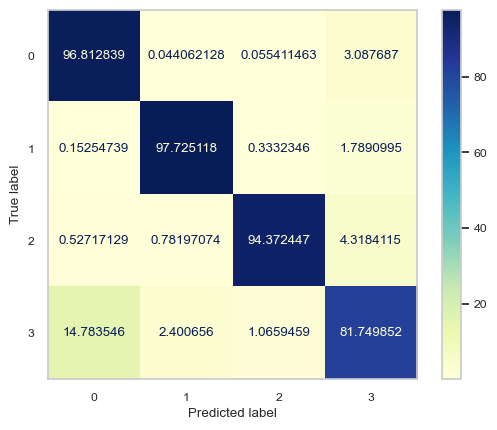

In [82]:
cm = confusion_matrix(y_train , results_DT, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("DT_cm.png",bbox_inches='tight' )


In [83]:
print(classification_report(y_train,results_DT))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    299577
           1       0.97      0.98      0.97     67520
           2       0.95      0.94      0.95     22763
           3       0.82      0.82      0.82     65857

    accuracy                           0.95    455717
   macro avg       0.93      0.93      0.93    455717
weighted avg       0.95      0.95      0.95    455717



**Random Forest**

In [84]:
random_state = 42

model_RF=RandomForestClassifier(random_state=random_state)

scores=cross_val_score(model_RF, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


array([0.94197977, 0.93955631, 0.94188276, 0.9381844 , 0.94083744,
       0.93920219, 0.94231344, 0.93921166, 0.93871179, 0.94143474])

In [85]:
model_RF=RandomForestClassifier(random_state=random_state)

results_RF=cross_val_predict(model_RF,X_train,y_train,cv=cvk)

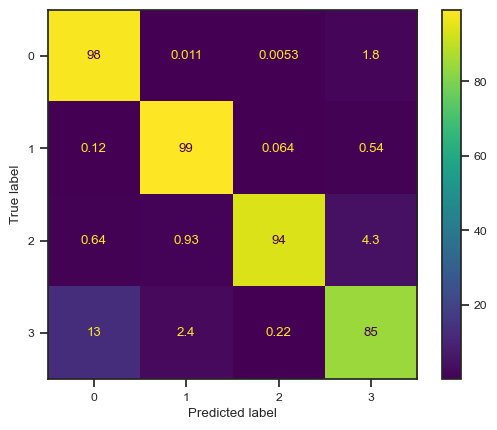

In [86]:
cm = confusion_matrix(y_train , results_RF, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) 
sns.set(font_scale=0.8 )
sns.set_style("ticks", {'axes.grid': False})
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="viridis" )

plt.savefig("RF_cm.png",bbox_inches='tight')


In [87]:
print(classification_report(y_train,results_RF))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    299577
           1       0.97      0.99      0.98     67520
           2       0.99      0.94      0.97     22763
           3       0.89      0.85      0.87     65857

    accuracy                           0.96    455717
   macro avg       0.96      0.94      0.95    455717
weighted avg       0.96      0.96      0.96    455717



In [88]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print("accuracy = " + str (accuracy_score(y_train,results_RF)))
print("precision = " + str (precision_score(y_train,results_RF,average="macro")))
print("recall = " + str (recall_score(y_train,results_RF,average="macro")))
print("F1 = " + str (f1_score(y_train,results_RF,average="macro")))
#print("FPR = " + str (FPR.mean()))

accuracy = 0.9616801655413337
precision = 0.9568467901332082
recall = 0.9403313387726083
F1 = 0.9482450233003539


**Logistic Regression**

In [89]:
random_state = 42

model_LR=LogisticRegression(random_state=random_state)

scores=cross_val_score(model_LR, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


array([0.73214758, 0.73102179, 0.72863531, 0.72755254, 0.72578475,
       0.73074368, 0.73427739, 0.72926294, 0.73206311, 0.7304036 ])

In [90]:
model_LR=LogisticRegression(random_state=random_state)

results_LR=cross_val_predict(model_LR,X_train,y_train,cv=cvk)

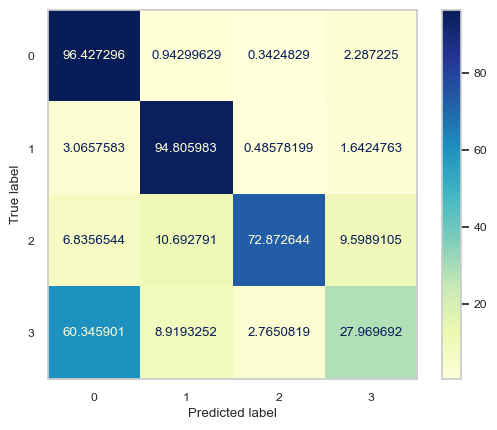

In [91]:
cm = confusion_matrix(y_train , results_LR, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("LR_cm.png",bbox_inches='tight')


In [92]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree",
"RandomForest","LogisticRegression"]})

In [93]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


In [94]:
inplace=True
temp=cv_res

In [95]:
temp

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


In [96]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


In [97]:
temp

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


In [98]:
temp=temp.reset_index(drop=True)

temp

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


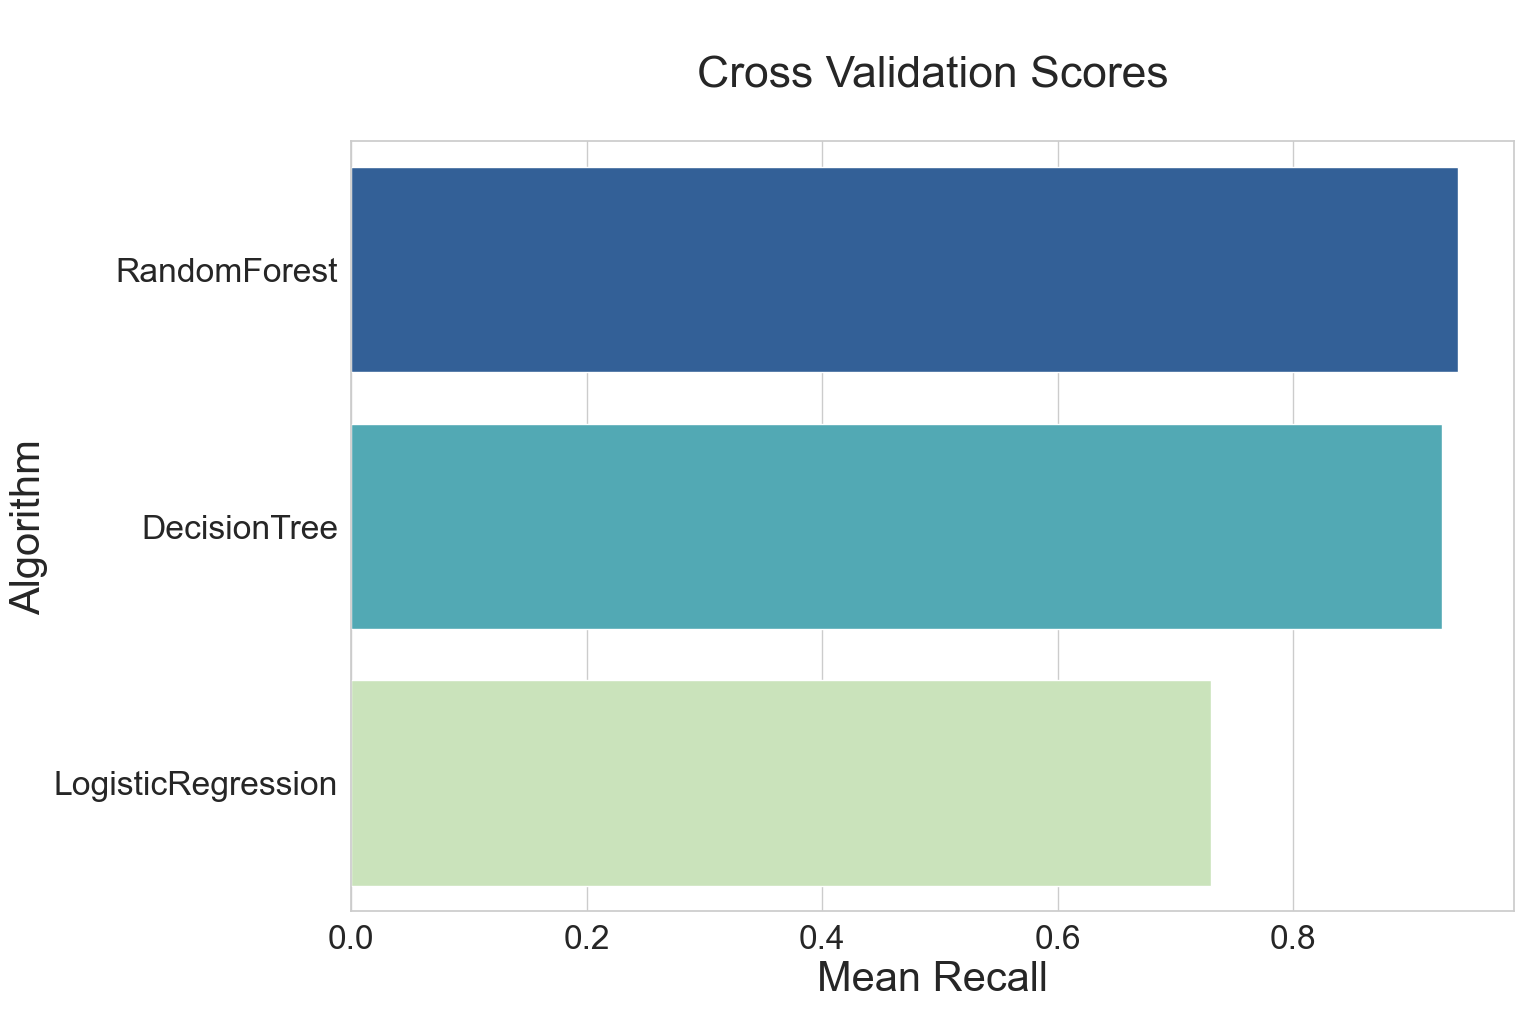

In [99]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=2.2)
sns.set_style("whitegrid")

# Make sure 'temp' is a Pandas DataFrame with 'CrossValMeans' and 'Algorithm' columns
# Assuming 'temp' has already been defined in your environment

# Sort the dataframe
sorted_temp = temp.sort_values(["CrossValMeans"], ascending=False)

# Create the barplot
g = sns.barplot(x="CrossValMeans", y="Algorithm", data=sorted_temp, palette="YlGnBu_r", orient="h")
g.set_xlabel("Mean Recall", fontsize=30)
g.set_ylabel("Algorithm", fontsize=30)
g.set_title("\nCross Validation Scores\n", fontsize=32)

# Save the figure
plt.savefig("all_score.png", bbox_inches='tight')
